In [5]:
import numpy as np 
import scipy
import scipy.signal
import scipy.io.wavfile
import matplotlib.pyplot as plt

# Creating Gaussian Model that we create after using PCA to reduce dimensionality

In [6]:
def gaussian(data, mean, cov, reshape=False):
    if reshape:
        data=np.reshape(data, (len(data),1))
    zero_mean = data - mean
    cov_inv = np.linalg.inv(cov)
    temp =  -0.5 *(zero_mean.T.dot(cov_inv).dot(zero_mean))
    determinant = np.linalg.det(cov)
    numerator = np.exp(temp)
    denomenator = np.sqrt(2*np.pi*determinant)
    gaussian_prob = numerator/denomenator 
    return gaussian_prob

In [7]:
def PCA(x, k):
   # Obtain column wise zero-mean
    '''If the input mean is not zero, bad things happen, we know this from lecture! 
    Therefore, we need to make sure that our data is zero-mean, 
    so instead of using 𝐗 we use 𝐗_mean'''
    means = np.mean(x, axis=1)
    means = np.reshape(means, (means.shape[0], 1))
    x_mean = x - means
   
    # Get the covariance of our zero-mean matrix
    cov_mat = np.cov(x_mean)
    '''As we were told by the TA,  Doing an eigen decomposition on the covariance matrix 
    (instead of doing it directly on the data matrix 𝐗, by SVD) is a easier starting point''' 

    eigenVal,eigenVec = scipy.sparse.linalg.eigsh(cov_mat, k = k)
#     print("Eigen Vectors shape : " + str(eigenVec.shape))
    
    #Calculate feature matrix
    w = np.linalg.inv(np.diag(np.sqrt(eigenVal))).dot(eigenVec.T)
    
    # Calculate weight matrix
    z = np.dot(w, x_mean)
    
    return w, z,means

In [8]:
def find_mean_and_cov(x):
# returns mean and covariance for given sample class
    mean = np.mean(x, axis=1)
    mean = np.reshape(mean, (len(mean),1))
    zero_mean = x - mean
    cov = zero_mean.dot(zero_mean.T) / (zero_mean.shape[1]-1)
    return mean, cov

In [27]:
def chunkify(sample):
    #10260 is the number of rows thats freq x 20. 
    #I'm just making a zeros matrix to be able to hstack/vstack conveniniently, and discard the first column before returning.

    newMat = np.zeros((51300,1))
#     rem = 1300 - sample.shape[1]
#     zeros = np.zeros((rem, 513))
    chunked = []
#     sample = sample.T
#     sample = np.vstack((sample, zeros))
#     sample = sample.T
    for colNum in range(0, np.shape(sample)[1], 100):
        matrix = sample[:,colNum:colNum+100]
        matrix = matrix.flatten('F')
        matrix = np.reshape(matrix, (matrix.shape[0], 1))
        #print("Chunkify matrix shape", matrix.shape)
        newMat = np.hstack((newMat, matrix))
    return newMat[:,1:]

In [10]:
def testing(z_test,noise_mean, noise_cov,  bird_mean, bird_cov, noise_threshold):
    def isBird(sample):
        sample = np.reshape(sample, (sample.shape[0],1))
        noyes = gaussian(sample,noise_mean, noise_cov)
        birdz = gaussian(sample,bird_mean, bird_cov)
        #print("Bird: ", birdz, " Noise: ", noyes)
        if birdz>noyes:
            return True
        else:
            return False
    n=z_test.shape[1]
    True_noise = 0
    False_bird = 0
    True_bird = 0
    False_noise = 0
    print("Now:", noise_threshold, n)
    for i in range(noise_threshold):
        if isBird(z_test[:,i]):
            False_bird+=1
        else:
            True_noise+=1

    for i in range(noise_threshold,n):
        if isBird(z_test[:,i]):
            True_bird+=1
        else:
            False_noise+=1
    
    print("true bird: ", True_bird)
    print("false noise: ", False_noise)
    print("true noise: ", True_noise)
    print("false bird: ", False_bird)

    trues = True_bird + True_noise
    falses = False_noise + False_bird
    percent = (trues/(trues+falses))*100
    print("Accuracy: ",percent, "%")

In [96]:
def doTheThings(blog, nlog):
    chunked = chunkify(blog)
    np.random.shuffle(chunked.T)
    print("Shape of chunked birds: ", np.shape(chunked))
    chunked_noise = chunkify(nlog)
    np.random.shuffle(chunked_noise.T)
    print("Shape of chunked noise: ",np.shape(chunked_noise))
    bird_threshold = int(np.shape(chunked)[1] * 0.8)
    noise_threshold =int(np.shape(chunked_noise)[1] * 0.8)
    noise_test = chunked_noise[:,noise_threshold:]
    print("Noise test shape: ", noise_test.shape)
    noise_train = chunked_noise[:,:noise_threshold]
    bird_test = chunked[:,bird_threshold:]
    bird_train = chunked[:,:bird_threshold]
    
    #Ensure it makes sense
    print("Shape of brid train: ", bird_train.shape)
    print("Shape of noise train: ", noise_train.shape)
    
    #stack for training & testing
    all_train= np.hstack((noise_train, bird_train))
    print("All train shape:", all_train.shape)
    all_test = np.hstack((noise_test, bird_test))
    print("All test shape: ",all_test.shape)
    
    
    from sklearn.decomposition import PCA
    pca = PCA(n_components=8)
    means = np.mean(all_train, axis=1)
    means = np.reshape(means, (means.shape[0], 1))
    pca.fit(all_train.T)  
    z_pca = pca.fit_transform(all_train.T).T
    z_pca.shape
    z_test = pca.components_.dot(all_test-means)
    noise_z = z_pca[:, :noise_threshold]
    bird_z = z_pca[:, noise_threshold:]
    print("Shape of noise_z", noise_z.shape)
    print("Shape of bird_z", bird_z.shape)
    noise_mean, noise_cov = find_mean_and_cov(noise_z)
    bird_mean, bird_cov = find_mean_and_cov(bird_z)
    testing(z_test, noise_mean, noise_cov,  bird_mean, bird_cov, noise_test.shape[1])

## Working on generating models with noise and bird data from multiple sites: GGA_B and GGA_C

In [98]:
path = "/Users/sushazad/Documents/GitHub/ISSE_cleaned/"
filename = "birdAutoGen22050.wav"
sample1, bsound1 = scipy.io.wavfile.read(path+filename)
print(sample1)
print(bsound1.shape)
filename = "ZuzanaBirdzClean.wav"
sample2, bsound2 = scipy.io.wavfile.read(path+filename)
print(sample2)
print(bsound2.shape)
bsound2 = np.reshape(bsound2, (bsound2.shape[0],1))
bsound = np.reshape(bsound, (bsound.shape[0],1))
print(bsound.shape)
print(bsound2.shape)
totBirds = np.vstack((bsound, bsound2))[:,0]
print("Total birds:",totBirds.shape)
bf, bt, bZxx = scipy.signal.stft(totBirds, fs=sample,window='hann', noverlap=768, nperseg=1024)
bmag = np.abs(bZxx)
blog = np.log(bmag)
print(blog.shape)

22050
(3834495,)
22050
(1306264,)
(7668990, 1)
(1306264, 1)
Total birds: (8975254,)
(513, 35061)


In [99]:
path = "/Users/sushazad/Documents/GitHub/ISSE_cleaned/"
filename = "NoiseAutoGen22050.wav"
sample1, nsound1 = scipy.io.wavfile.read(path+filename)
print(sample1)
print(nsound1.shape)
filename = "ZuzanaNoiseClean.wav"
sample2, nsound2 = scipy.io.wavfile.read(path+filename)
print(sample2)
print(nsound2.shape)
nsound2 = np.reshape(nsound2, (nsound2.shape[0],1))
nsound = np.reshape(nsound, (nsound.shape[0],1))
print(nsound.shape)
print(nsound2.shape)
totNoise = np.vstack((nsound, nsound2))[:,0]
print("Total noise :",totNoise.shape)
totNoise = totNoise[:totBirds.shape[0]]
print("Total noise cropped :",totNoise.shape)
nf, nt, nZxx = scipy.signal.stft(totNoise, fs=sample,window='hann', noverlap=768, nperseg=1024)
nmag = np.abs(nZxx)
nlog = np.log(nmag)
print(nlog.shape)

22050
(4579785,)
22050
(1389172,)
(7668990, 1)
(1389172, 1)
Total noise : (9058162,)
Total noise cropped : (8975254,)
(513, 35061)


In [100]:
print(np.shape(blog))
print(np.shape(nlog))

(513, 35061)
(513, 35061)


In [101]:
blog = blog[:,:35000]
print(np.shape(blog))
nlog = nlog[:,:35000]
doTheThings(blog, nlog)

(513, 35000)
Shape of chunked birds:  (51300, 350)
Shape of chunked noise:  (51300, 350)
Noise test shape:  (51300, 70)
Shape of brid train:  (51300, 280)
Shape of noise train:  (51300, 280)
All train shape: (51300, 560)
All test shape:  (51300, 140)
Shape of noise_z (8, 280)
Shape of bird_z (8, 280)
Now: 70 140
true bird:  49
false noise:  21
true noise:  68
false bird:  2
Accuracy:  83.57142857142857 %


## Working On GGA_B dataset

In [127]:
path = ""
filename = "birdAutoGen.wav"
sample, bsound = scipy.io.wavfile.read(path+filename)
print(sample)
print(bsound.shape[0])
bf, bt, bZxx = scipy.signal.stft(bsound, fs=sample,window='hann', noverlap=768, nperseg=1024)
bmag = np.abs(bZxx)
blog = np.log(bmag)

44100
7668990


In [128]:
path = ""
filename = "NoiseAutoGen.wav"
sample, nsound = scipy.io.wavfile.read(path+filename)
print(sample)
print(nsound.shape)
nsound = nsound[:bsound.shape[0]]
print(nsound.shape)
nf, nt, nZxx = scipy.signal.stft(nsound, fs=sample,window='hann', noverlap=768, nperseg=1024)
nmag = np.abs(nZxx)
nlog = np.log(nmag)

44100
(9159570,)
(7668990,)


In [129]:
print(np.shape(blog))
print(np.shape(nlog))

(513, 29958)
(513, 29958)


In [130]:
blog = blog[:,:29900]
print(np.shape(blog))
nlog = nlog[:,:29900]
doTheThings(blog, nlog)

(513, 29900)
Shape of chunked birds:  (51300, 299)
Shape of chunked noise:  (51300, 299)
Noise test shape:  (51300, 60)
Shape of brid train:  (51300, 239)
Shape of noise train:  (51300, 239)
All train shape: (51300, 478)
All test shape:  (51300, 120)
Shape of noise_z (8, 239)
Shape of bird_z (8, 239)
Now: 60 120
true bird:  46
false noise:  14
true noise:  55
false bird:  5
Accuracy:  84.16666666666667 %


## Directly testing on GGA_C data 
Testing on sections where there were birds heard very faintly through rain

In [44]:
def retesting(z_test,noise_mean, noise_cov,  bird_mean, bird_cov, noise_threshold):
    def reisBird(sample):
        sample = np.reshape(sample, (sample.shape[0],1))
        noyes = gaussian(sample,noise_mean, noise_cov)
        birdz = gaussian(sample,bird_mean, bird_cov)
        #print("Bird: ", birdz, " Noise: ", noyes)
        if birdz>noyes:
            return True
        else:
            return False
    n=z_test.shape[1]
    True_noise = 0
    False_bird = 0
    True_bird = 0
    False_noise = 0
    print("Now:", noise_threshold, n)
    for i in range(n):
        if reisBird(z_test[:,i]):
            True_bird+=1
        else:
            False_noise+=1
    
    print("true bird: ", True_bird)
    print("false noise: ", False_noise)


    percent = (True_bird/n)*100
    print("Accuracy: ",percent, "%")

In [45]:
def redoTheThings(blog, nlog, test_sound):
    chunked = chunkify(blog)
    np.random.shuffle(chunked.T)
    print("Shape of chunked birds: ", np.shape(chunked))
    chunked_noise = chunkify(nlog)
    np.random.shuffle(chunked_noise.T)
    print("Shape of chunked noise: ",np.shape(chunked_noise))
    bird_threshold = int(np.shape(chunked)[1] * 0.8)
    noise_threshold =int(np.shape(chunked_noise)[1] * 0.8)
    noise_test = chunked_noise[:,noise_threshold:]
    print("Noise test shape: ", noise_test.shape)
    noise_train = chunked_noise[:,:noise_threshold]
    bird_test = chunked[:,bird_threshold:]
    bird_train = chunked[:,:bird_threshold]
    
    
    #Ensure it makes sense
    print("Shape of brid train: ", bird_train.shape)
    print("Shape of noise train: ", noise_train.shape)
    
    #stack for training & testing
    all_train= np.hstack((noise_train, bird_train))
    print("All train shape:", all_train.shape)

    
    
    from sklearn.decomposition import PCA
    pca = PCA(n_components=8)
    means = np.mean(all_train, axis=1)
    means = np.reshape(means, (means.shape[0], 1))
    pca.fit(all_train.T)  
    z_pca = pca.fit_transform(all_train.T).T
    z_pca.shape
    noise_z = z_pca[:, :noise_threshold]
    bird_z = z_pca[:, noise_threshold:]
    print("Shape of noise_z", noise_z.shape)
    print("Shape of bird_z", bird_z.shape)
    noise_mean, noise_cov = find_mean_and_cov(noise_z)
    bird_mean, bird_cov = find_mean_and_cov(bird_z)
    
    
    tf, tt, testZxx = scipy.signal.stft(test_sound, fs=22050,window='hann', noverlap=768, nperseg=1024)
    testmag = np.abs(testZxx)
    testlog = np.log(testmag)
    print("testlog shape",testlog.shape)
    testlog = testlog[:, :23300]
    chunked_test = chunkify(testlog)
    print("All test shape: ",chunked_test.shape)
    z_test = pca.components_.dot(chunked_test-means)
    
    retesting(z_test, noise_mean, noise_cov,  bird_mean, bird_cov, noise_test.shape[1])

In [47]:
path = "/Users/sushazad/Documents/GitHub/ISSE_cleaned/"
filename = "birdAutoGen22050.wav"
sample1, bsound1 = scipy.io.wavfile.read(path+filename)
print(sample1)
print(bsound1.shape)
filename = "ZuzanaBirdzClean.wav"
sample2, bsound2 = scipy.io.wavfile.read(path+filename)
print(sample2)
print(bsound2.shape)
bsound2 = np.reshape(bsound2, (bsound2.shape[0],1))
bsound1 = np.reshape(bsound1, (bsound1.shape[0],1))
print(bsound1.shape)
print(bsound2.shape)
totBirds = np.vstack((bsound1, bsound2))[:,0]
print("Total birds:",totBirds.shape)
bf, bt, bZxx = scipy.signal.stft(totBirds, fs=sample1,window='hann', noverlap=768, nperseg=1024)
bmag = np.abs(bZxx)
blog = np.log(bmag)
print(blog.shape)

22050
(3834495,)
22050
(1306264,)
(3834495, 1)
(1306264, 1)
Total birds: (5140759,)
(513, 20083)


In [48]:
path = "/Users/sushazad/Documents/GitHub/ISSE_cleaned/"
filename = "NoiseAutoGen22050.wav"
sample1, nsound1 = scipy.io.wavfile.read(path+filename)
print(sample1)
print(nsound1.shape)
filename = "ZuzanaNoiseClean.wav"
sample2, nsound2 = scipy.io.wavfile.read(path+filename)
print(sample2)
print(nsound2.shape)
nsound2 = np.reshape(nsound2, (nsound2.shape[0],1))
nsound1 = np.reshape(nsound1, (nsound1.shape[0],1))
print(nsound1.shape)
print(nsound2.shape)
totNoise = np.vstack((nsound1, nsound2))[:,0]
print("Total noise :",totNoise.shape)
totNoise = totNoise[:totBirds.shape[0]]
print("Total noise cropped :",totNoise.shape)
nf, nt, nZxx = scipy.signal.stft(totNoise, fs=sample1,window='hann', noverlap=768, nperseg=1024)
nmag = np.abs(nZxx)
nlog = np.log(nmag)
print(nlog.shape)

22050
(4579785,)
22050
(1389172,)
(4579785, 1)
(1389172, 1)
Total noise : (5968957,)
Total noise cropped : (5140759,)
(513, 20083)


In [49]:
blog = blog[:, :20000]
nlog = nlog[:, :20000]

## Dont believe below results since we're only testing on bird data.  Suspect - rain is whats causing it to be classified as birds & not actually presence of birds.
Revisit with test data of noise with rain

In [50]:
path = "/Users/sushazad/Documents/GitHub/ISSE_cleaned/"
filename = "GGA_CbirdAutoGen22050.wav"
s, test_s = scipy.io.wavfile.read(path+filename)
print(s)
redoTheThings(blog, nlog, test_s)

22050
Shape of chunked birds:  (51300, 200)
Shape of chunked noise:  (51300, 200)
Noise test shape:  (51300, 40)
Shape of brid train:  (51300, 160)
Shape of noise train:  (51300, 160)
All train shape: (51300, 320)
Shape of noise_z (8, 160)
Shape of bird_z (8, 160)
testlog shape (513, 23319)
All test shape:  (51300, 233)
Now: 40 233
true bird:  233
false noise:  0
Accuracy:  100.0 %


## Working on small subsample of Zuzana Data

In [51]:
path = "/Users/sushazad/Documents/GitHub/ISSE_cleaned/"
filename = "ZuzanaBirdzClean.wav"
sample, bsound = scipy.io.wavfile.read(path+filename)
bf, bt, bZxx = scipy.signal.stft(bsound, fs=sample,window='hann', noverlap=768, nperseg=1024)
bmag = np.abs(bZxx)
blog = np.log(bmag)

In [46]:
path = "/Users/sushazad/Documents/GitHub/ISSE_cleaned/"
filename = "ZuzanaNoiseClean.wav"
sample, nsound = scipy.io.wavfile.read(path+filename)
print(sample)
print(nsound.shape)
nsound = nsound[:1306264]
nf, nt, nZxx = scipy.signal.stft(nsound, fs=sample,window='hann', noverlap=768, nperseg=1024)
nmag = np.abs(nZxx)
nlog = np.log(nmag)

22050
(1389172,)


In [47]:
print(nsound.shape)
print(bsound.shape)

(1306264,)
(1306264,)


In [48]:
print(np.shape(blog))
print(np.shape(nlog))

(513, 5104)
(513, 5104)


## Step 2
We now have lots of spectral vectors, that we can split into train and test. However, we know that we want to work with 1 second chunks. 
Let us use 20 frames as roughly one second worth of data.
We now need to transform our data so we stack all the frequencies per second into one column.And we should do this for every music sample's spectral vector.

1. The current shape of the log(abs(Zxx)) for one audio file's stft is = (freq) x (frames)

2. Pad the number of frames to have a number divisible by 20. Lets call this frames2 (where frames2 = frames + padding)

3. We therefore want our new shape to be: (freq x 20) x (frames2 / 20)

4. Once we have these 1 second chunks we want to stack them across all samples of that type (speech/music), so the resultant from the 'chunkify' function will contain all the samples from that class in one second 'chunks', with each column being 1 second's worth of frequencies.

In [49]:
blog = blog[:,:5100]
print(np.shape(blog))
nlog = nlog[:,:5100]
doTheThings(blog, nlog)

(513, 5100)
Shape of chunked birds:  (51300, 51)
Shape of chunked noise:  (51300, 51)
Noise test shape:  (51300, 11)
Shape of brid train:  (51300, 40)
Shape of noise train:  (51300, 40)
All train shape: (51300, 80)
All test shape:  (51300, 22)
Shape of noise_z (8, 40)
Shape of bird_z (8, 40)
Now: 11 22
Bird:  [[1.09628532e-13]]  Noise:  [[3.57252644e-11]]
Bird:  [[1.43600755e-13]]  Noise:  [[3.38812487e-13]]
Bird:  [[8.96151471e-14]]  Noise:  [[5.08660105e-12]]
Bird:  [[5.6966379e-14]]  Noise:  [[4.83104042e-11]]
Bird:  [[5.77100389e-14]]  Noise:  [[3.75999041e-14]]
Bird:  [[1.26098701e-13]]  Noise:  [[9.00352571e-12]]
Bird:  [[1.11306515e-13]]  Noise:  [[1.89261801e-11]]
Bird:  [[1.41044733e-13]]  Noise:  [[2.47243128e-12]]
Bird:  [[1.20339476e-13]]  Noise:  [[1.3024374e-11]]
Bird:  [[6.40825045e-14]]  Noise:  [[3.94745303e-13]]
Bird:  [[2.55090461e-14]]  Noise:  [[2.17381005e-11]]
Bird:  [[1.48089992e-13]]  Noise:  [[5.76786148e-48]]
Bird:  [[7.40915135e-14]]  Noise:  [[3.50987417e-3

# Trying NMF

In [63]:
def nmf(x, k): 
    freqs = x.shape[0]
    times = x.shape[1]
    w = np.random.rand(freqs, k)
    h = np.random.rand(k, times)

    #Small constant to avoid division by 0 
    mew=1e-6
    for i in range(100):
        # Compute a new h based on previous h and w
        numerator = np.dot(np.transpose(w), x)
        denominator = np.dot(np.dot( np.transpose(w), w), h)
        h = h * numerator / (denominator + mew) 
        # Compute a new w based on this newly computed h and old w
        numerator = np.dot(x, np.transpose(h))
        denominator = np.dot(w, np.dot( h, np.transpose(h)))
        w = w * numerator / (denominator + mew)
    return h, w
    

In [86]:
def plot_lines(features, weights, method="Hahahaha"):
    x = list(range(0,len(features[0])))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,8))

    fig.suptitle(str(method+' Features'), fontsize=15)
    ax1.plot(features[0], x)
    ax1.set_ylabel("Frequency [Hz]")
    ax1.set_title("Feature 1")
    ax2.plot(features[1], x)
    ax2.set_ylabel("Frequency [Hz]")
    ax2.set_title("Feature 2")
#     ax3.plot(features[2], x)
#     ax3.set_ylabel("Frequency [Hz]")
#     ax3.set_title("Feature 3")
    fig.tight_layout()
        
#     x = list(range(0,len(features[0])))
#     fig, (ax4, ax5, ax6) = plt.subplots(2, 1, figsize=(6,8))

#     fig.suptitle(str(method+' Weights'), fontsize=15)
#     ax4.plot(features[0])
#     ax4.set_xlabel("Time [ms]")
#     ax4.set_title("Feature 1")
#     ax5.plot(features[1])
#     ax5.set_xlabel("Time [ms]")
#     ax5.set_title("Feature 2")
#     ax6.plot(features[2])
#     ax6.set_xlabel("Time [ms]")
#     ax6.set_title("Feature 3")
#     fig.tight_layout(rect=[0, 0.02, 1, 0.97])

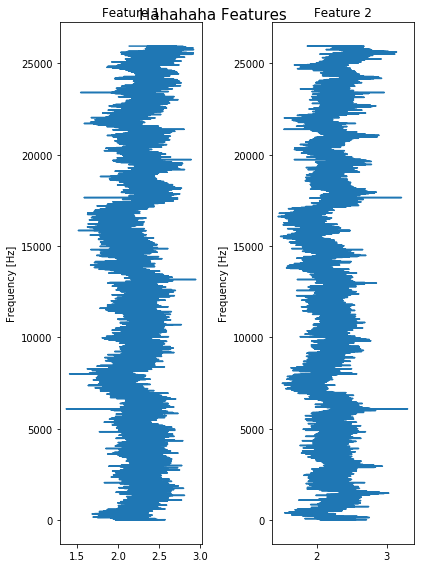

In [87]:
plot_lines(w_nmf, h_nmf)

In [90]:
path = "/Users/sushazad/Documents/GitHub/ISSE_cleaned/"
filename = "ZuzanaCombined.wav"
zcsample, zcsound = scipy.io.wavfile.read(path+filename)
zcf, zct, zcZxx = scipy.signal.stft(zcsound, fs=sample,window='hann', noverlap=768, nperseg=1024)
zcmag = np.abs(zcZxx)
zclog = np.sqrt(zcmag)
print(zcsample)
print(zcsound.shape)
print(np.shape(zclog))

22050
(6642783,)
(513, 25950)


In [91]:
w_nmf, h_nmf = nmf(zclog, 2)

 ...]

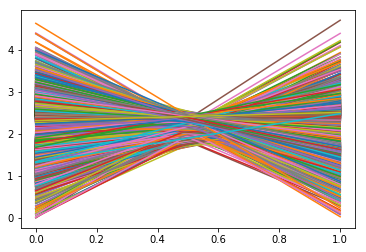

In [78]:
plt.plot(w_nmf)

In [79]:
plt.show()

Text(0.5, 0, 'Time [sec]')

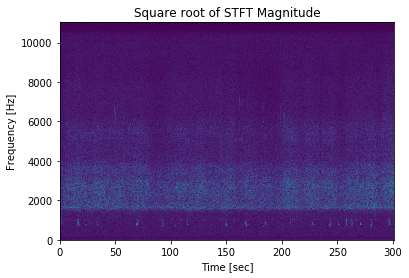

In [92]:
plt.pcolormesh(zct,zcf, zclog)
plt.title('Square root of STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')